<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Calculate-albedo" data-toc-modified-id="Calculate-albedo-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Calculate albedo</a></span></li>


In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from utility import analysis_parameters as ap, util
import numpy as np
import dask
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

In [2]:
region="TWP"
n=10 # n=40 for 0.25 deg or n=10 for 1 deg or anything for native grid

In [4]:
chunk_dict = {"time":500, "lat":400, "lon":1440} # "grid_size":500000}
chunk_dictn = {"time":100, "ncells":100} 
chunk_dicts = {"time":500, "ncol":1000, "grid_size":1000} 

sa_olr = xr.open_dataset(ap.get_file("SAM", "TWP", "rlt"), chunks=chunk_dict).rlt
sa_swn = xr.open_dataset(ap.get_file("SAM", "TWP", "rst"), chunks=chunk_dict).rstacc
ds = xr.open_dataset(ap.get_file("DATA", "TWP", "rad"), chunks=chunk_dict)
da_olr = ds.adj_atmos_lw_up_all_toa_1h
da_swu = ds.adj_atmos_sw_up_all_toa_1h
da_swd = ds.adj_atmos_sw_down_all_toa_1h
ni_olr = xr.open_dataset(ap.get_file("NICAM", "TWP", "rlut"), chunks=chunk_dict).rlut
ni_swu = xr.open_dataset(ap.get_file("NICAM", "TWP", "rsut"), chunks=chunk_dict).rsut
ni_swd = xr.open_dataset(ap.get_file("NICAM", "TWP", "rsdt"), chunks=chunk_dict).rsdt
um_olr = xr.open_dataset(ap.get_file("UM", "TWP", "rlut"), chunks=chunk_dict).rlut
um_swu = xr.open_dataset(ap.get_file("UM", "TWP", "rsut"), chunks=chunk_dict).rsut
um_swd = xr.open_dataset(ap.get_file("UM", "TWP", "rsdt"), chunks=chunk_dict).rsdt

if n==10 or n==40:
    ge_olr = xr.open_dataset(ap.get_file("GEOSr0.25deg", "TWP", "rlut"), chunks=chunk_dict).rlut
    ge_swu = xr.open_dataset(ap.get_file("GEOSr0.25deg", "TWP", "rsut"), chunks=chunk_dict).rsut
    ge_swn = xr.open_dataset(ap.get_file("GEOSr0.25deg", "TWP", "rst"), chunks=chunk_dict).rst
    ge_swd = ge_swu+ge_swn
    sc_olr = xr.open_dataset(ap.get_file("SCREAMr0.25deg", "TWP", "rlt"), chunks=chunk_dict).rlt
    sc_swn = xr.open_dataset(ap.get_file("SCREAMr0.25deg", "TWP", "rst"), chunks=chunk_dict).rst
    sc_swd = xr.open_dataset(ap.get_file("SCREAMr0.25deg", "TWP", "rsdt"), chunks=chunk_dict).SOLIN
else:
    ge_olr = xr.open_dataset(ap.get_file("GEOS", "TWP", "rlut"), chunks=chunk_dict).rlut
    ge_swu = xr.open_dataset(ap.get_file("GEOS", "TWP", "rsut"), chunks=chunk_dict).rsut
    ge_swd = xr.open_dataset(ap.get_file("GEOS", "TWP", "rsdt"), chunks=chunk_dict).rsdt
    sc_olr = xr.open_dataset(ap.get_file("SCREAM", "TWP", "rlt"), chunks=chunk_dicts).rlt
    sc_swn = xr.open_dataset(ap.get_file("SCREAM", "TWP", "rst"), chunks=chunk_dicts).rst
    sc_swd = xr.open_dataset(ap.get_file("SCREAM", "TWP", "rsdt"), chunks=chunk_dicts).SOLIN.rename({"ncol":"grid_size"})

sc_swu = sc_swd-sc_swn

In [5]:
sc_swu

<xarray.DataArray (time: 2880, lat: 40, lon: 40)>
dask.array<sub, shape=(2880, 40, 40), dtype=float32, chunksize=(500, 40, 40), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2020-01-30 00:00:00 ... 2020-02-28 23:45:00
  * lon      (lon) float64 143.1 143.4 143.6 143.9 ... 152.1 152.4 152.6 152.9
  * lat      (lat) float64 -4.875 -4.625 -4.375 -4.125 ... 4.375 4.625 4.875

# Coarsen 

In [13]:
if n==10:
    ge_olr = ge_olr.coarsen(lat=4, lon=4, boundary='trim').mean()
    ge_swu = ge_swu.coarsen(lat=4, lon=4, boundary='trim').mean()
    ge_swd = ge_swd.coarsen(lat=4, lon=4, boundary='trim').mean()
    sc_olr = sc_olr.coarsen(lat=4, lon=4, boundary='trim').mean()
    sc_swu = sc_swu.coarsen(lat=4, lon=4, boundary='trim').mean()
    sc_swd = sc_swd.coarsen(lat=4, lon=4, boundary='trim').mean()
    print("n=10")
if n==10 or n==40:
    ni_olr = ni_olr.coarsen(lat=len(ni_olr.lat)//n, lon=len(ni_olr.lon)//n, boundary='trim').mean()
    ni_swu = ni_swu.coarsen(lat=len(ni_swu.lat)//n, lon=len(ni_swu.lon)//n, boundary='trim').mean()
    ni_swd = ni_swd.coarsen(lat=len(ni_swd.lat)//n, lon=len(ni_swd.lon)//n, boundary='trim').mean()
    sa_olr = sa_olr.coarsen(lat=len(sa_olr.lat)//n, lon=len(sa_olr.lon)//n, boundary='trim').mean()
    sa_swn = sa_swn.coarsen(lat=len(sa_swn.lat)//n, lon=len(sa_swn.lon)//n, boundary='trim').mean()
    um_olr = um_olr.coarsen(latitude=len(um_olr.latitude)//n, longitude=len(um_olr.longitude)//n, boundary='trim').mean()
    um_swu = um_swu.coarsen(latitude=len(um_swu.latitude)//n, longitude=len(um_swu.longitude)//n, boundary='trim').mean()
    um_swd = um_swd.coarsen(latitude=len(um_swd.latitude)//n, longitude=len(um_swd.longitude)//n, boundary='trim').mean()




# Calculate albedo


$ alb = \frac{sw_{up}}{sw_{down}} $ 

In [14]:
if n==10 or n==40:
    sa_swd = ge_swd.interp(time=sa_swn.time,
                           lat=sa_swn.lat, 
                           lon=sa_swn.lon, 
                           method="nearest",
                           kwargs={"fill_value": np.nan})    
else:
    sa_swn = sa_swn.interp(time=um_swd.time, method="nearest",
                       kwargs={"fill_value": np.nan})
    sa_olr = sa_olr.interp(time=um_swd.time, method="nearest",
                           kwargs={"fill_value": np.nan})
    sa_swd = um_swd.interp(latitude=sa_swn.lat, 
                           longitude=sa_swn.lon, 
                           method="nearest",
                           kwargs={"fill_value": np.nan})
sa_swu = sa_swd - sa_swn

In [15]:
ni_alb = ni_swu/ni_swd
sa_alb = sa_swu/sa_swd.where(sa_swd>100)
um_alb = um_swu/um_swd
da_alb = da_swu/da_swd
ge_alb = ge_swu/ge_swd
sc_alb = sc_swu/sc_swd.values

[########################################] | 100% Completed |  0.1s


In [16]:
# um_swn = um_swd-um_swu
# fig, ax = plt.subplots(2,1,figsize=(12,6))
# sc_swn.mean(axis=(1,2)).plot(label="SW net", ax=ax[0])
# sc_swu.mean(axis=(1,2)).plot(label="upwelling SW", ax=ax[0])
# sc_swd.mean(axis=(1,2)).plot(label="downwelling SW", ax=ax[0])
# # ax[0].plot(ge_swd.time, ge_swd.mean(axis=(1,2)), label="GEOS downwelling SW", linestyle="--")
# sc_alb = (sc_swu/sc_swd.values)
# sc_alb.where(sc_alb.time.dt.hour<=4).mean(axis=(1,2)).plot(ax=ax[1], label="alb") # 
# axt=ax[1].twinx()
# sc_olr.mean(axis=(1,2)).plot(ax=axt, color="C1", label="OLR")
# ax[1].legend(loc="upper left")
# axt.legend(loc="upper right")
# ax[1].set_ylabel("albedo")
# ax[1].set_ylim([0,0.8])
# fig.suptitle("SCREAM TWP")
# ax[0].legend()
# # plt.savefig("../plots/scream_0.25deg_twp-swd-swn-swu.png", dpi=120)
# plt.show()

In [17]:
## diurnal cycle
# alb_di = sc_alb.groupby(sc_alb.time.dt.hour).mean().mean(dim=["lat","lon"])
# olr_di = sc_olr.groupby(sc_olr.time.dt.hour).mean().mean(dim=["lat","lon"])

# fig, ax = plt.subplots(1,1,figsize=(4,3))
# axt = ax.twinx()
# alb_di.plot(ax=ax, color="C0", label="alb")
# olr_di.plot(ax=axt, color="C1", label="OLR")

# ax.legend(loc="upper left")
# axt.legend(loc="upper right")
# plt.show()

In [18]:
da_olr.shape, da_alb.shape, da_swu.shape, da_swd.shape

((2184, 10, 10), (2184, 10, 10), (2184, 10, 10), (2184, 10, 10))

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
45500
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  2.8s
960000
[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  3.6s
252150
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.5s
296100
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
960000
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.2s
960000


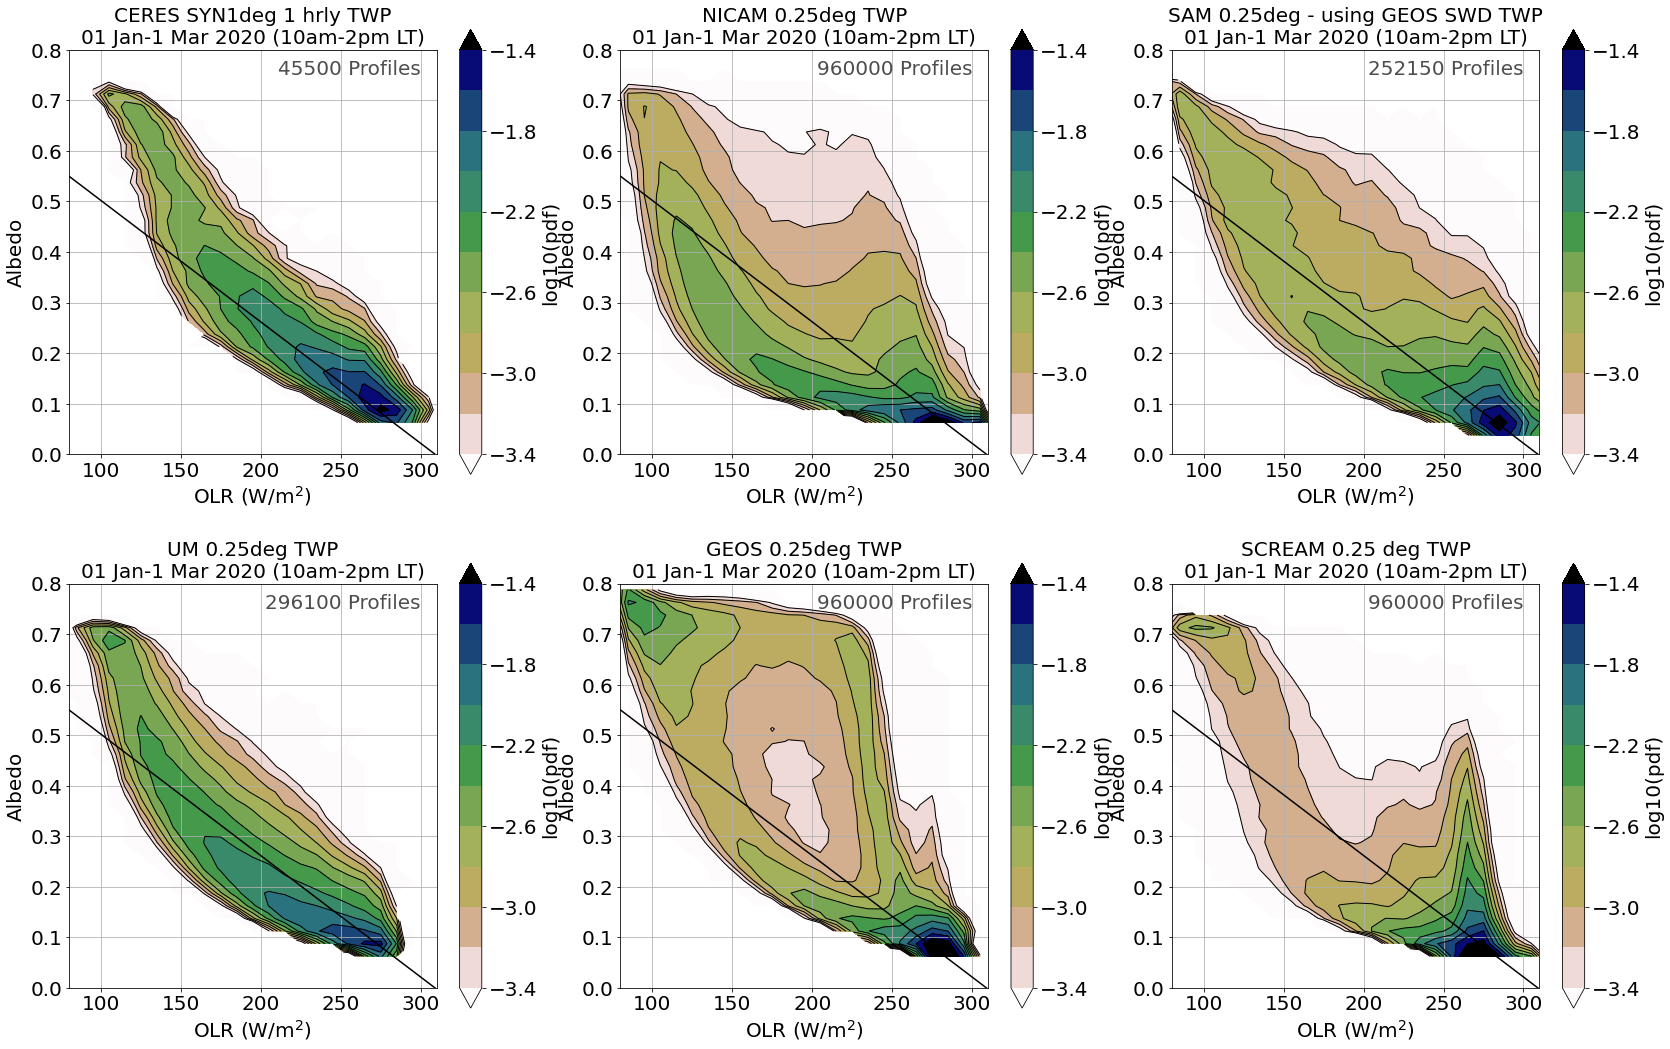

In [19]:
if n==10:
    models=["CERES SYN1deg 1 hrly", "NICAM 1x1", "SAM 1x1 - using GEOS SWD", 
            "UM 1x1", "GEOS 1x1", "SCREAM 1x1"]
elif n==40:
    models=["CERES SYN1deg 1 hrly", "NICAM 0.25deg", "SAM 0.25deg - using GEOS SWD", 
            "UM 0.25deg", "GEOS 0.25deg", "SCREAM 0.25 deg"]
else:
    models=["CERES SYN1deg 1 hrly", "NICAM native", "SAM native - using UM SWD", 
            "UM native", "GEOS native", "SCREAM native"]
fig = plt.figure(figsize=(28,18))
axes = [fig.add_subplot(2,3,i,box_aspect=1.1) for i in range(1,len(models)+1)]
i = 0
olrs=[da_olr, ni_olr, sa_olr, um_olr, ge_olr, sc_olr]
albs=[da_alb, ni_alb, sa_alb, um_alb, ge_alb, sc_alb]
for i in range(len(olrs)):
    olr = olrs[i]
    alb = albs[i]
    olr = olr.where((olr.time.dt.hour>=0)&(olr.time.dt.hour<=4))
    alb = alb.where((alb.time.dt.hour>=0)&(alb.time.dt.hour<=4))
    util.dennisplot("density",olr.values.flatten(), alb.values.flatten(), 
                    ax=axes[i], model=models[i], region=region, 
                    cmap="gist_earth_r", levels=np.arange(-3.4,-1.2,0.2))
    axes[i].set_xlabel("OLR (W/m$^2$)")
    axes[i].set_ylabel("Albedo")
    axes[i].grid(True)
    axes[i].set_ylim([0,0.8])
    axes[i].set_title("{} {}\n01 Jan-1 Mar 2020 (10am-2pm LT)".format(models[i], region), 
                      fontsize=20)
    i+=1
if n==40:
    plt.savefig("../plots/TWP/jhist0.25deg_{}.png".format(region))
elif n==10:
    plt.savefig("../plots/TWP/jhist1deg_{}.png".format(region))
else:
    plt.savefig("../plots/TWP/jhistnative_{}.png".format(region))
plt.show()

In [14]:
print("DATA:   " + str(int(da_olr.mean().values)) + "   " + str(da_alb.where(da_alb.time.dt.hour<4).mean().values)+\
      "\nNICAM:  " + str(int(ni_olr.mean().values)) + "   " + str(ni_alb.where(ni_alb.time.dt.hour<4).mean().values)+\
      "\nSAM:    " + str(int(sa_olr.mean().values)) + "   " + str( sa_alb.where(sa_alb.time.dt.hour<4).mean().values)+\
      "\nUM:     " + str(int(um_olr.mean().values)) + "   " + str(um_alb.where(um_alb.time.dt.hour<4).mean().values)+\
      "\nGEOS:   " + str(int(ge_olr.mean().values)) + "   " + str(ge_alb.where(ge_alb.time.dt.hour<4).mean().values)+\
      "\nSCREAM  " + str(int(sc_olr.mean().values)) + "   " + str(sc_alb.where(sc_alb.time.dt.hour<4).mean().values)
     )


[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  0.8s
[########################################] | 100% Completed |  9.5s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  3.1s
[########################################] | 100% Completed |  7.7s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  3.0s
DATA:   222   0.238015
NICAM:  216   0.21504568
SAM:    232   0.22683641
UM:     199   0.26681897
GEOS:   223   0.2893087
SCREAM  245   0.16268528


# GEOS high albedo high OLR values

In [20]:
ge_iwp = xr.open_dataset(ap.get_file("GEOSr0.25deg", "clivi", "TWP")).clivi
ge_lwp = xr.open_dataset(ap.get_file("GEOSr0.25deg", "clwvi", "TWP")).clwvi
ge_iwp, ge_lwp  

(<xarray.DataArray 'clivi' (time: 3253, lat: 40, lon: 40)>
 [5204800 values with dtype=float32]
 Coordinates:
   * time     (time) datetime64[ns] 2020-01-30 ... 2020-03-03T21:00:00
   * lon      (lon) float64 143.1 143.4 143.6 143.9 ... 152.1 152.4 152.6 152.9
   * lat      (lat) float64 -4.875 -4.625 -4.375 -4.125 ... 4.375 4.625 4.875
 Attributes:
     standard_name:  atmosphere_mass_content_of_cloud_ice
     long_name:      ice_water_path
     units:          kg m-2
     origin:         IWP,
 <xarray.DataArray 'clwvi' (time: 3253, lat: 40, lon: 40)>
 [5204800 values with dtype=float32]
 Coordinates:
   * time     (time) datetime64[ns] 2020-01-30 ... 2020-03-03T21:00:00
   * lon      (lon) float64 143.1 143.4 143.6 143.9 ... 152.1 152.4 152.6 152.9
   * lat      (lat) float64 -4.875 -4.625 -4.375 -4.125 ... 4.375 4.625 4.875
 Attributes:
     standard_name:  atmosphere_mass_content_of_cloud_condensed_water
     long_name:      liquid_water_path
     units:          kg m-2
     origin

In [12]:
# t = 2867
# for t in range(t,t+25):
#     fig, ax = plt.subplots(2,2, figsize=(12,10))
    
#     ge_olr[t].plot.pcolormesh(vmin=80, vmax=300, cmap="viridis_r", ax=ax[0,0])
#     ge_alb[t].plot.pcolormesh(vmin=0.05, vmax=0.8, cmap="viridis", ax=ax[0,1], label="Mean alb={0:0.2g}".format(ge_alb[t].mean().values))
#     ax[0,0].annotate("Mean OLR={}".format(int(ge_olr[t].mean().values)), xy=(0.1,0.1), xycoords="axes fraction", backgroundcolor="w")
#     ax[0,1].annotate("Mean Alb={0:0.2g}".format((ge_alb[t].mean().values)), xy=(0.1,0.1), xycoords="axes fraction", backgroundcolor="w")

#     print(ge_olr[t].mean().values, ge_alb[t].mean().values)

#     ge_iwp[t].plot.pcolormesh(vmin=1e-5, vmax=1, cmap="viridis", ax=ax[1,0])
#     ge_lwp[t].plot.pcolormesh(vmin=1e-5, vmax=1, cmap="viridis", ax=ax[1,1])
#     ax[1,0].annotate("Mean IWP={0:0.2g} kg/m2".format((ge_iwp[t].mean().values)), xy=(0.1,0.1), xycoords="axes fraction", backgroundcolor="w")
#     ax[1,1].annotate("Mean LWP={0:0.2g} kg/m2".format((ge_lwp[t].mean().values)), xy=(0.1,0.1), xycoords="axes fraction", backgroundcolor="w")
#     plt.savefig("../plots/TWP/GEOS-albolriwplwp/g{0:0>4}.png".format(t))
#     plt.close()

# SCREAM weird olr alb values


In [13]:
sc_iwp = xr.open_dataset(ap.get_file("SCREAMr0.25deg", "TWP", "clivi")).clivi
# sc_lwp = xr.open_dataset(ap.get_file("SCREAMr0.25deg", "TWP", "clwvi")).clwvi
sc_iwp#, sc_lwp

<xarray.DataArray 'clivi' (time: 2880, lat: 40, lon: 40)>
[4608000 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2020-01-30 ... 2020-02-28T23:45:00
  * lon      (lon) float64 143.1 143.4 143.6 143.9 ... 152.1 152.4 152.6 152.9
  * lat      (lat) float64 -4.875 -4.625 -4.375 -4.125 ... 4.375 4.625 4.875
Attributes:
    standard_name:  atmosphere_mass_content_of_cloud_ice
    long_name:      ice_water_path
    units:          kg m-2
    origin:         IWP

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
181.26788 0.39572203


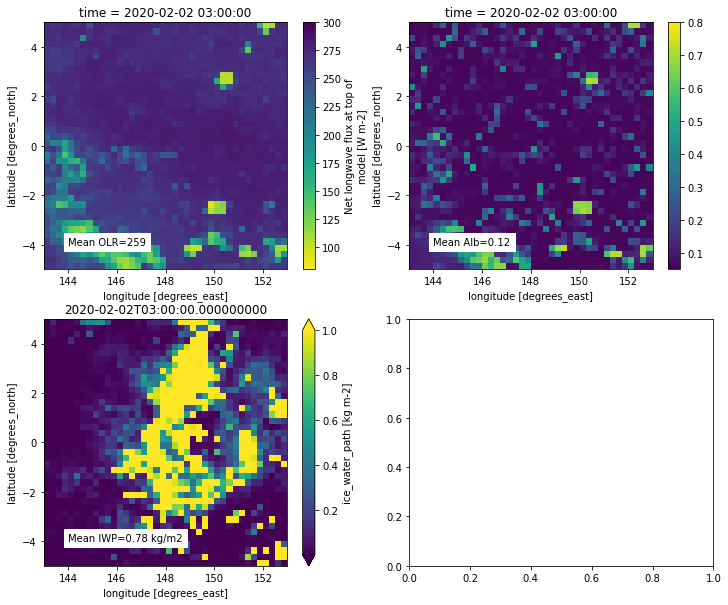

In [102]:
t = 300

# for t in range(t,t+1):
fig, ax = plt.subplots(2,2, figsize=(12,10))

sc_olr[t].plot.pcolormesh(vmin=80, vmax=300, cmap="viridis_r", ax=ax[0,0])
sc_alb[t].plot.pcolormesh(vmin=0.05, vmax=0.8, cmap="viridis", ax=ax[0,1], label="Mean alb={0:0.2g}".format(ge_alb[t].mean().values))
ax[0,0].annotate("Mean OLR={}".format(int(sc_olr[t].mean().values)), xy=(0.1,0.1), xycoords="axes fraction", backgroundcolor="w")
ax[0,1].annotate("Mean Alb={0:0.2g}".format((sc_alb[t].mean().values)), xy=(0.1,0.1), xycoords="axes fraction", backgroundcolor="w")

print(ge_olr[t].mean().values, ge_alb[t].mean().values)
# levs = np.logspace(-9,1,25)
# levs = np.linspace(-5,1,12)
sc_iwp[t].plot.pcolormesh(vmin=1e-5, vmax=1, cmap="viridis", ax=ax[1,0]) #  
ax[1,0].set_title(sc_iwp[t].time.values)
# sc_lwp[t].plot.pcolormesh(vmin=1e-5, vmax=1, cmap="viridis", ax=ax[1,1])
ax[1,0].annotate("Mean IWP={0:0.2g} kg/m2".format((sc_iwp[t].mean().values)), xy=(0.1,0.1), xycoords="axes fraction", backgroundcolor="w")
# ax[1,1].annotate("Mean LWP={0:0.2g} kg/m2".format((ge_lwp[t].mean().values)), xy=(0.1,0.1), xycoords="axes fraction", backgroundcolor="w")
plt.savefig("../plots/TWP/SCREAM-albolriwplwp/s{0:0>4}.png".format(t))
plt.show()

[########################################] | 100% Completed |  2.7s
[########################################] | 100% Completed |  2.8s


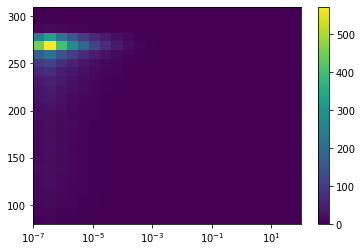

In [117]:
plt.hist2d(sc_iwp.values.flatten(), sc_olr.values.flatten(), density=True, 
           bins=[np.logspace(-7,2,25), np.linspace(80,310,26)])# np.linspace(0,1,26)])# 
plt.xscale('log')
plt.colorbar()
plt.show()

In [118]:
sc_olr.shape, sc_alb.shape, sc_iwp.shape

((2880, 40, 40), (2880, 40, 40), (2880, 40, 40))

[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.7s
[########################################] | 100% Completed |  3.2s
[########################################] | 100% Completed |  3.3s


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

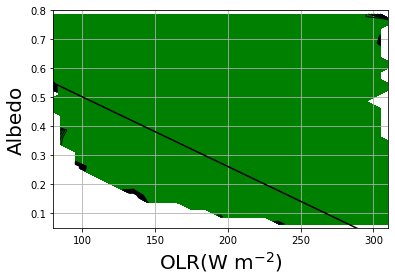

In [119]:
util.dennisplot("mean",sc_olr.values.flatten(), sc_alb.values.flatten(), var=sc_iwp.values.flatten())